# Visualizing a priori SBMs

In [1]:
cd '/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_connectome/'

/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_connectome


In [2]:
from pkg.data import load_maggot_graph
from joblib import Parallel, delayed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import networkx as nx
from graspologic.utils import cartesian_product, import_graph, binarize, remove_loops
from graspologic.models import SBMEstimator
from graspologic.plot import heatmap
from graspologic.simulations import er_nm
from graspologic.models.sbm import _get_block_indices, _calculate_block_p, _block_to_full
from sklearn.utils import check_X_y
from scipy.stats import norm, binom_test

In [3]:
context = sns.plotting_context(context="poster", font_scale=1.2)
sns.set_context(context)

In [4]:


def model_sbm(adj, cls_name):
    if len(cls_name) == 1:
        sbm = SBMEstimator()
        sbm.fit(binarize(adj), y=meta[cls_name].values)
    elif len(cls_name) == 2:  # crossing 'hemisphere' w/ another class
        multi_labels = meta[cls_name[0]].astype(str) + meta[cls_name[1]].astype(str)
        # assuming the first class is 'hemisphere'
        sbm = SBMEstimator()
        sbm.fit(binarize(adj), y=multi_labels)
    return sbm

def generate_rand_block_p(adj, y, rep=100, n_jobs=5):
    def _run():
        g = er_nm(len(adj), np.count_nonzero(adj), directed=True)
        sbm_ = SBMEstimator()
        sbm_.fit(binarize(g), y=y)
        return sbm_.block_p_
    rand_block_p = Parallel(n_jobs=n_jobs, verbose=1)(delayed(_run)()
        for _ in range(rep))
    return np.mean(rand_block_p, axis=0)

def compute_block_sig(adj, cls_name, p_mat, n_rand=100):
    labeled = np.where(meta[cls_name].ne(''))[0]
    adj_new = adj[np.ix_(labeled, labeled)]
    block_vert_inds, block_inds, block_inv = _get_block_indices(meta[cls_name].iloc[labeled])
    block_count = _calculate_block_p(binarize(adj_new), block_inds, block_vert_inds, True)
    rand_block_p = generate_rand_block_p(adj_new, meta[cls_name].iloc[labeled], n_rand)
    n_blocks = len(block_inds)
    block_pairs = cartesian_product(block_inds, block_inds)
    block_p = np.zeros((n_blocks, n_blocks))
    p_val = []
    for p in block_pairs:
        from_block = p[0]
        to_block = p[1]
        from_inds = block_vert_inds[from_block]
        to_inds = block_vert_inds[to_block]
        block = binarize(adj)[from_inds, :][:, to_inds]
        p_val.append(round(binom_test(block_count[p[0], p[1]],
            block.size, rand_block_p[p[0], p[1]], alternative='greater'), 4))
    return p_val, block_pairs

def plot_heatmap(B, new_labels, p_val, block_pairs):
    fig = plt.figure(constrained_layout=True, figsize=(38,20))
    gs = fig.add_gridspec(12, 20)
    ax = fig.add_subplot(gs[2:13,1:12])
    heatmap(B, xticklabels=new_labels, yticklabels=new_labels, ax=ax, norm=LogNorm())
    for i in range(len(block_pairs)):
        if p_val[i] <= 0.05:
            if p_val[i] <= 0.005:
                if p_val[i] <= 0.0005:
                    ax.text(block_pairs[i,1], block_pairs[i,0]+0.5,'***', color='w', fontsize=20)
                else:
                    ax.text(block_pairs[i,1], block_pairs[i,0]+0.5,'**', color='w', fontsize=20)
            else:
                ax.text(block_pairs[i,1], block_pairs[i,0]+0.5,'*', color='w', fontsize=20)
    ax.set_xticklabels(new_labels, rotation=45, ha='right')
    ax.set_yticklabels(new_labels, rotation=45)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    ax.hlines(split,colors='gray', linestyles='dashed', linewidth=1.5, *ax.get_xlim())
    ax.vlines(split,colors='gray', linestyles='dashed', linewidth=1.5, *ax.get_xlim())
    ax = fig.add_subplot(gs[6:,15:])
    ax.hist(p_val, bins=[0, 0.0001, 0.001, 0.01, 0.1, 1])
    ax.set_yscale('symlog')
    ax.set_xscale('symlog',linthreshx=0.0001)
    ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
    ax.set_xticklabels(ax.get_xticks(), fontsize=30, rotation=45)
    ax.set_yticklabels(ax.get_yticks(), fontsize=30)
    ax.set_xlabel('p-value', fontsize=30)
    ax.set_ylabel('count', fontsize=30)
    # plt.savefig('cls4_wei',transparent=False, facecolor='white', bbox_inches = "tight")

def plot_connectivity(cls, block_pairs, B, p_val):
    new_keys = np.array(list(cls.keys()))
    counts = []
    for k in new_keys:
        idx = np.where(new_keys == k)[0][0]
        n = np.sum(meta['class_4'] == idx)
        counts.append(n)
    nodes = range(len(new_keys))
    labels = {}
    for n in nodes:
        labels[n] = new_keys[n].split('_')[-1]
    edges = block_pairs[np.where(np.array(p_val)<0.005)[0]]
    edges = [tuple(edges[i,:]) for i in range(edges.shape[0])]
    weights = B.ravel()[np.where(np.array(p_val)<0.005)[0]]
    weights = [((i-np.min(weights)) / (np.max(weights)-np.min(weights))) * 1.5
        for i in weights]
    pos = {0:[0,11], 1:[2.25,11], 2:[4.5,11], 3:[6.75,11], 4:[9,11], 5:[11.25,11], 6:[13.5,11],
        7:[0,7], 8:[2,7], 9:[4,7], 10:[6,7], 11:[8,7],
        12:[0,1], 13:[2,1], 14:[3.5,3], 15:[3.5,-1.5], 16:[5,1],
        18:[8,1], 19:[10,1], 20:[12,1], 21:[15,-13],
        17:[4.5,-8], 
        22:[1,-19], 23:[4.5,-19], 
        24:[1,-23], 25:[4.5,-23], 26:[8,-23]}

    fig, ax = plt.subplots(1, figsize=(8,10))
    ax.set_xlim([-5,18])
    ax.set_ylim([-24,16.5])
    g = nx.MultiDiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    nx.draw_networkx_nodes(g, node_size=counts, pos=pos, ax=ax)
    label_pos = pos.copy()
    offset_size = 0.8
    for i in pos.keys():
        # for j in range(2):
        #     label_pos[i][j] = pos[i][j] + counts[i]/1200 + offset_size[j]
        label_pos[i] = [j+counts[i]/1000+offset_size for j in pos[i]]
    label_pos[13][1] = 1.5
    i = -1
    for e in g.edges:
        i += 1
        ax.annotate("",
                    xy=pos[e[1]], xycoords='data',
                    xytext=pos[e[0]], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="0.5",
                                    shrinkA=5+counts[e[0]]/50,
                                    shrinkB=5+counts[e[1]]/50,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=0.1",
                                    mutation_scale=10, lw=weights[i],
                                    ),
                    )
    ax.axis('off')
    for i in range(len(edges)):
        if edges[i][0] == edges[i][1]:
            gap = counts[edges[i][0]] / 600 + 0.3
            center = tuple([pos[edges[i][0]][0], pos[edges[i][0]][1]+gap])
            l = mpl.patches.Arc(center,0.3,0.5,0,-60,240,
                lw=weights[i], color='0.5')
            ax.add_patch(l)
    nx.draw_networkx_labels(g, pos=label_pos, labels=labels, font_color='r', ax=ax)
    ypos_ = [11,7,0.5,-8,-19,-23]
    texts = ['Input', '2nd-Order', '3rd-Order','4th-Order','Nth-1 Order','Nth Order']
    for i in range(len(texts)):
        ax.text(-2.5, ypos_[i], texts[i], ha='center', va='center', fontsize=10)

    plt.show()

def _calculate_block_p_wei(graph, block_inds, block_vert_inds, return_counts=False):
    n_blocks = len(block_inds)
    block_pairs = cartesian_product(block_inds, block_inds)
    block_p = np.zeros((n_blocks, n_blocks))
    for p in block_pairs:
        from_block = p[0]
        to_block = p[1]
        from_inds = block_vert_inds[from_block]
        to_inds = block_vert_inds[to_block]
        block = graph[from_inds, :][:, to_inds]
        if np.count_nonzero(block) == 0:
            p = 0
        else:
            p = np.sum(block) / np.count_nonzero(block)
        block_p[from_block, to_block] = p
    return block_p

def weighted_sbm(adj, y):
    graph = import_graph(adj)
    check_X_y(graph, y)
    graph = remove_loops(graph)
    block_vert_inds, block_inds, block_inv = _get_block_indices(y)
    block_p = _calculate_block_p_wei(graph, block_inds, block_vert_inds)
    p_mat = _block_to_full(block_p, block_inv, graph.shape)
    p_mat = remove_loops(p_mat)
    return block_p, p_mat

def generate_rand_block_p_wei(adj, y, rep=100, n_jobs=5):
    def _run():
        g = er_nm(len(adj), np.count_nonzero(adj), directed=True)
        edges = adj[np.nonzero(adj)]
        np.random.shuffle(edges)
        g[np.nonzero(g)] = edges
        r_block_p, _ = weighted_sbm(g, y)
        return r_block_p
    rand_block_p = Parallel(n_jobs=n_jobs, verbose=1)(delayed(_run)()
        for _ in range(rep))
    return rand_block_p

def compute_block_sig_wei(block_p, adj, cls_name, n_rand=100):
    _, block_inds, _ = _get_block_indices(meta[cls_name])
    rand_block_p = generate_rand_block_p_wei(adj, meta[cls_name], n_rand)
    block_pairs = cartesian_product(block_inds, block_inds)
    p_val = []
    for p in block_pairs:
        null = [i[p[0], p[1]] for i in rand_block_p]
        if np.mean(null) == 0 and block_p[p[0], p[1]] == 0:
            p_val.append(1)
        else:
            # print(np.mean(null), np.std(null), block_p[p[0], p[1]])
            z_score = (block_p[p[0], p[1]] - np.mean(null)) / np.std(null)
            p_val.append(round(1 - norm.cdf(z_score)))
    return p_val, block_pairs


#%%[markdown]
# ### load the data

In [5]:
mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"]]
mg.fix_pairs()
meta = mg.nodes.copy()
adj = mg.sum.adj.copy()

#%%[markdown]
# ### grap information on labels from different columns of meta

In [6]:
class_4 = {'sens_AN': [["['sens_subclass_AN']"], 'all_class2'],
    'sens_olf': [["['sens_subclass_ORN']"], 'all_class2'],
    'sens_MN': [["['sens_subclass_MN']"], 'all_class2'],
    'sens_thermo': [["['sens_subclass_thermo']"], 'all_class2'],
    'sens_photo': [["['sens_subclass_photoRh5']",
        "['sens_subclass_photoRh6']"], 'all_class2'],
    'sens_vtd': [["['sens_subclass_vtd']"], 'all_class2'],
    'sens_ascending': [['ascendings'], 'simple_group'],
    'inter_uPN': [['uPN'], 'merge_class'],
    'inter_mPN': [['mPN'], 'merge_class'],
    'inter_tPN': [['tPN'], 'merge_class'],
    'inter_vPN': [['vPN'], 'merge_class'],
    'inter_unkPN': [],
    'inter_LHN': [['LHNs'], 'simple_group'],
    'inter_KC': [['KCs'], 'simple_group'],
    'inter_MBIN': [['MBINs'], 'simple_group'],
    'inter_MBON': [['MBONs'], 'simple_group'],
    'inter_FBN': [['MB-FBNs'], 'simple_group'],
    'inter_CN': [['CNs'], 'simple_group'],
    'inter_ALN': [['bLN','pLN','cLN'], 'merge_class'],
    'inter_LON': [['LON'], 'merge_class'],
    'inter_unkLN': [],
    'inter_unk': [['unk'], 'simple_group'],
    'out_pre-dVNC': [['pre-dVNCs'], 'simple_group'],
    'out_pre-dSEZ': [['pre-dSEZs'], 'simple_group'],
    'out_dVNC': [['dVNCs'], 'simple_group'],
    'out_dSEZ': [['dSEZs'], 'simple_group'],
    'out_RGN': [['RGNs'], 'simple_group'],
}

all_classes = {'class_4': class_4}
for ii, kk in enumerate(all_classes.keys()):
    meta[kk] = ''
    for idx, (k, v) in enumerate(all_classes[kk].items()):
        if len(v) == 1:
            meta.loc[meta[v[0]].eq(True).any(1), kk] = idx
        elif len(v) > 1:
            for i in range(len(v[0])):
                meta.loc[meta[v[1]].eq(v[0][i]), kk] = idx

# Some nodes that labeled as "PN" or "LN" in meta['simple_group']
# are labeled as things like "AN2", "MN2" etc in meta['merge_class']
# that do not specify which "PN" or "LN"
# even though meta['merge_class'] gives detailed labels for the majority of nodes
# so in order not to exclude any node, we will label them as "unkPN" or "unkLN"
idx = list(class_4.keys()).index("inter_unkPN")
meta.loc[(meta['class_4'].eq('') & meta['simple_group'].eq('PNs')), 'class_4'] = idx
idx = list(class_4.keys()).index("inter_unkLN")
meta.loc[(meta['class_4'].eq('') & meta['simple_group'].eq('LNs')), 'class_4'] = idx
print(len(meta['class_4'].values))

2874


In [7]:
# class_1: 3-block (input, interneuron, output)
meta['class_1'] = ''
meta.loc[meta['class_4'].isin(range(7)), 'class_1'] = 0
meta.loc[meta['class_4'].isin(range(7, 22)), 'class_1'] = 1
meta.loc[meta['class_4'].isin(range(22, 27)), 'class_1'] = 2 
print(len(meta['class_1'].values))

#%%[markdown]
# ### fit an SBM for each category and test significance on the B_ij's

2874


In [8]:
all_classes = ['class_1', 'simple_group', 'class_4']
sbms = []
sbms_hemi = []
for k in all_classes:
    sbms.append(model_sbm(adj, [k]))
    sbms_hemi.append(model_sbm(adj, ['hemisphere', k]))

/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.7-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.7-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.7-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

In [9]:
cls_name = 'class_4'
sbm_id = all_classes.index(cls_name)
p_val, block_pairs = compute_block_sig(adj, cls_name, sbms[sbm_id].p_mat_, 500)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   38.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.6min
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:  4.0min finished


In [10]:
# for class_4
cls = class_4
labels = list(cls.keys())
new_labels = [i.split('_')[-1] for i in labels]
B = sbms[sbm_id].block_p_
split = [7, 24]

# # for 'simple_group'
# idx = [14,9,7,2,1,5,6,4,0,3,15,13,12,11,10,8]  # indices for reordering
# labels = list(np.unique(meta['simple_group'], return_inverse=True)[0])
# new_labels = [labels[i] for i in idx]
# B = sbms[sbm_id].block_p_[np.ix_(idx, idx)]
# p_val = np.array(p_val).reshape(B.shape)[np.ix_(idx, idx)].ravel()
# split = [2, 11]

/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


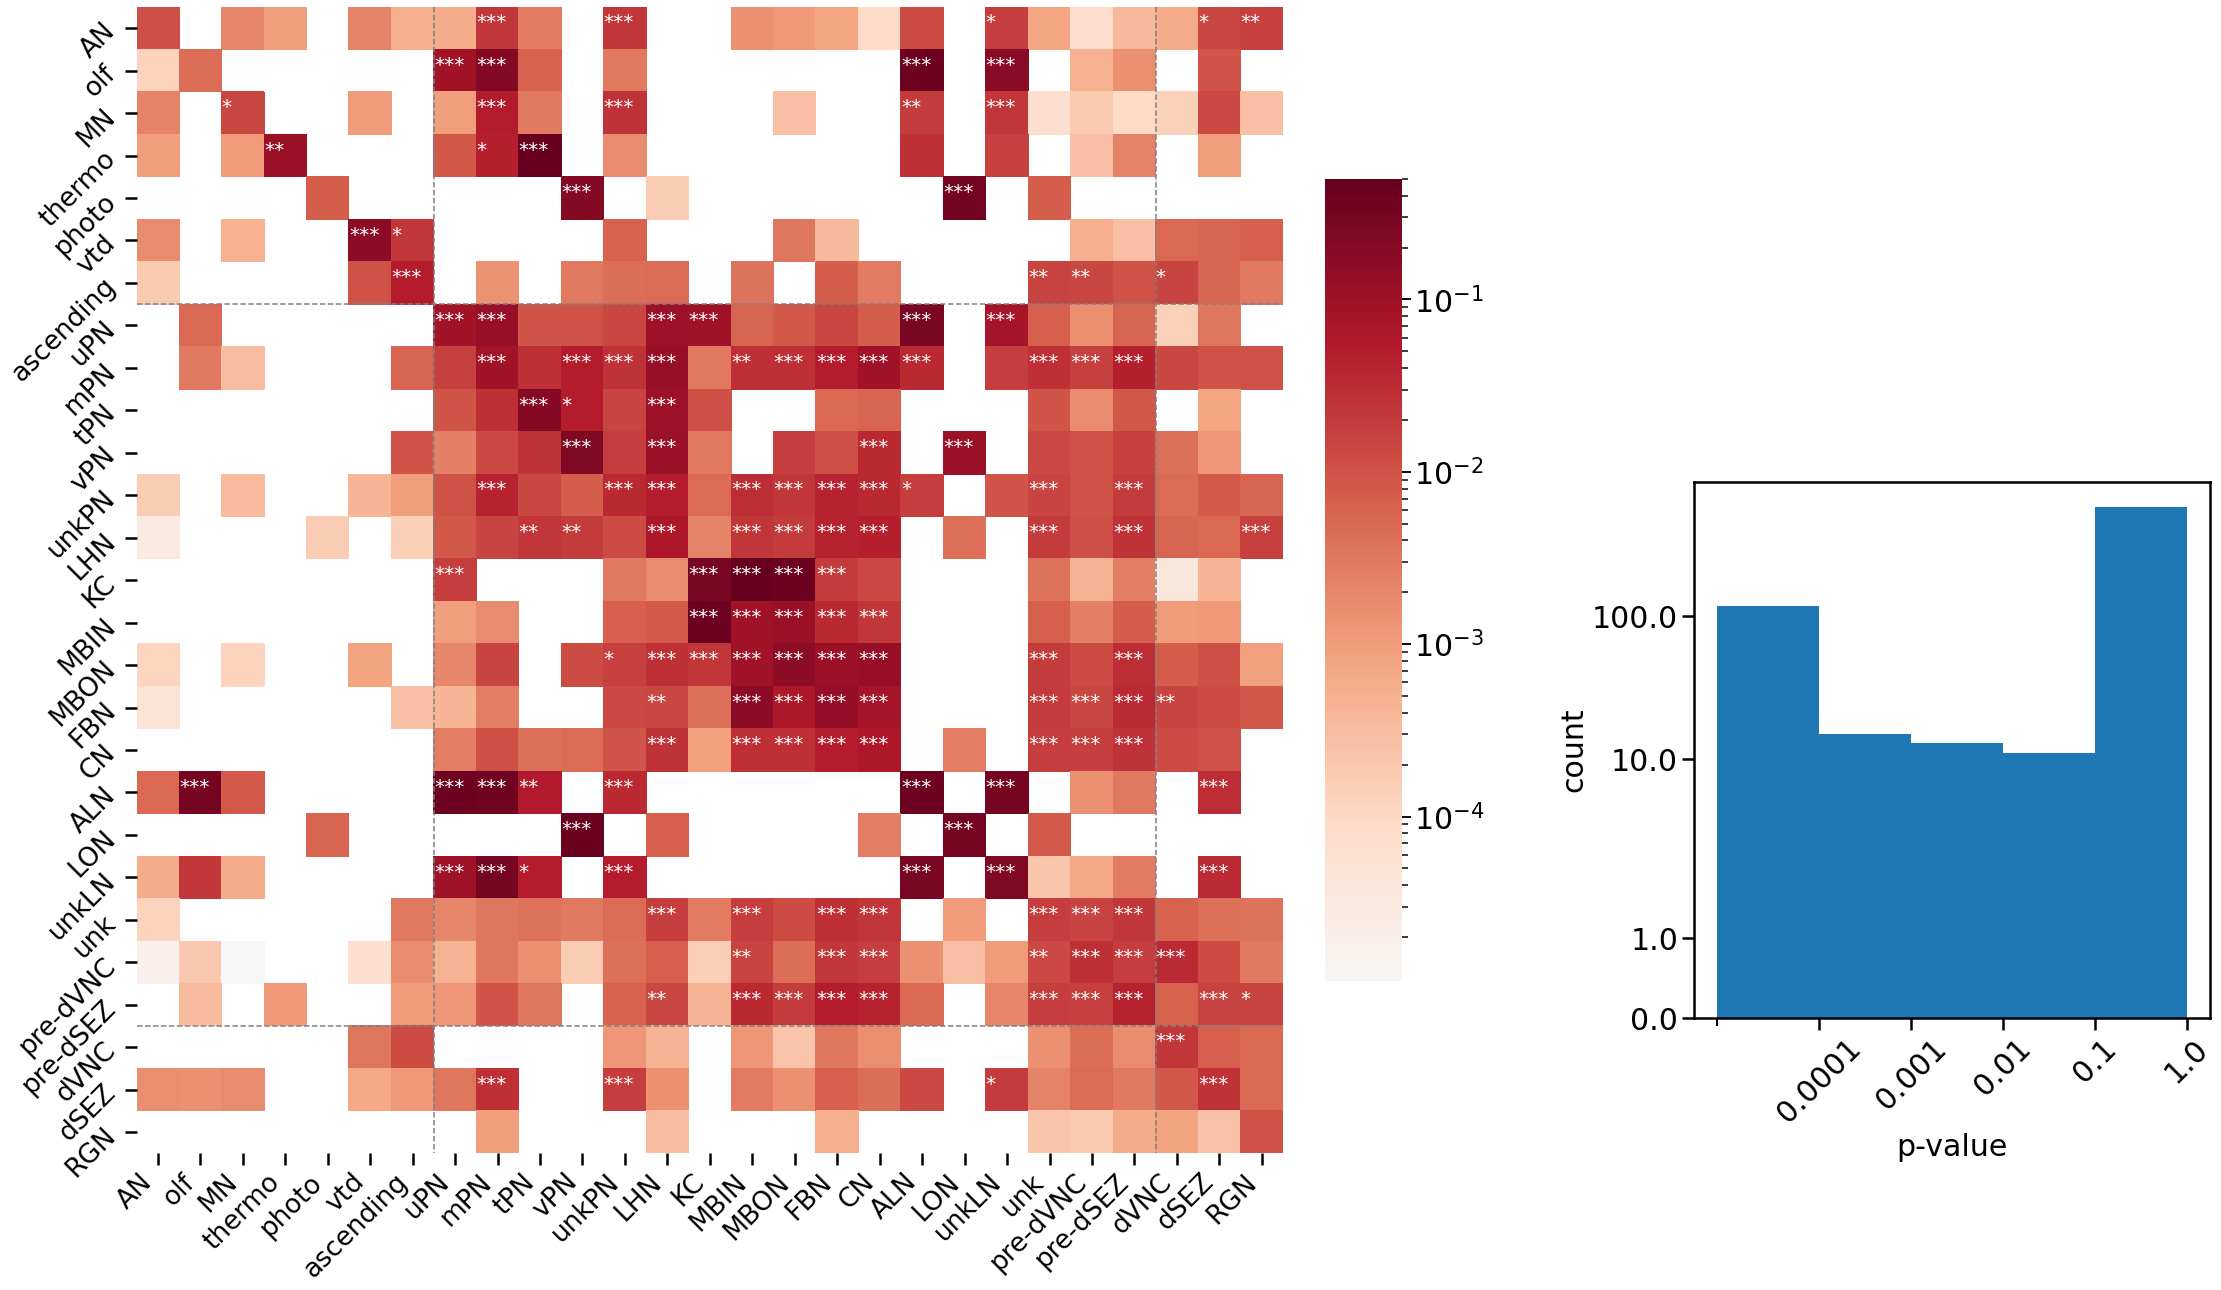

In [11]:
plot_heatmap(B, new_labels, p_val, block_pairs)

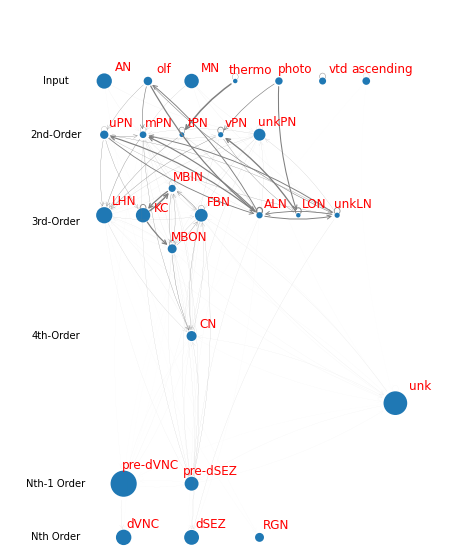

In [12]:
plot_connectivity(class_4, block_pairs, B, p_val)

#%%[markdown]
# #### try to incorporate the edge weights

In [13]:
block_p, p_mat = weighted_sbm(adj, y=meta['class_4'].values)

In [14]:
p_val, block_pairs = compute_block_sig_wei(block_p, adj, 'class_4', 500)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   20.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:  4.0min finished


/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


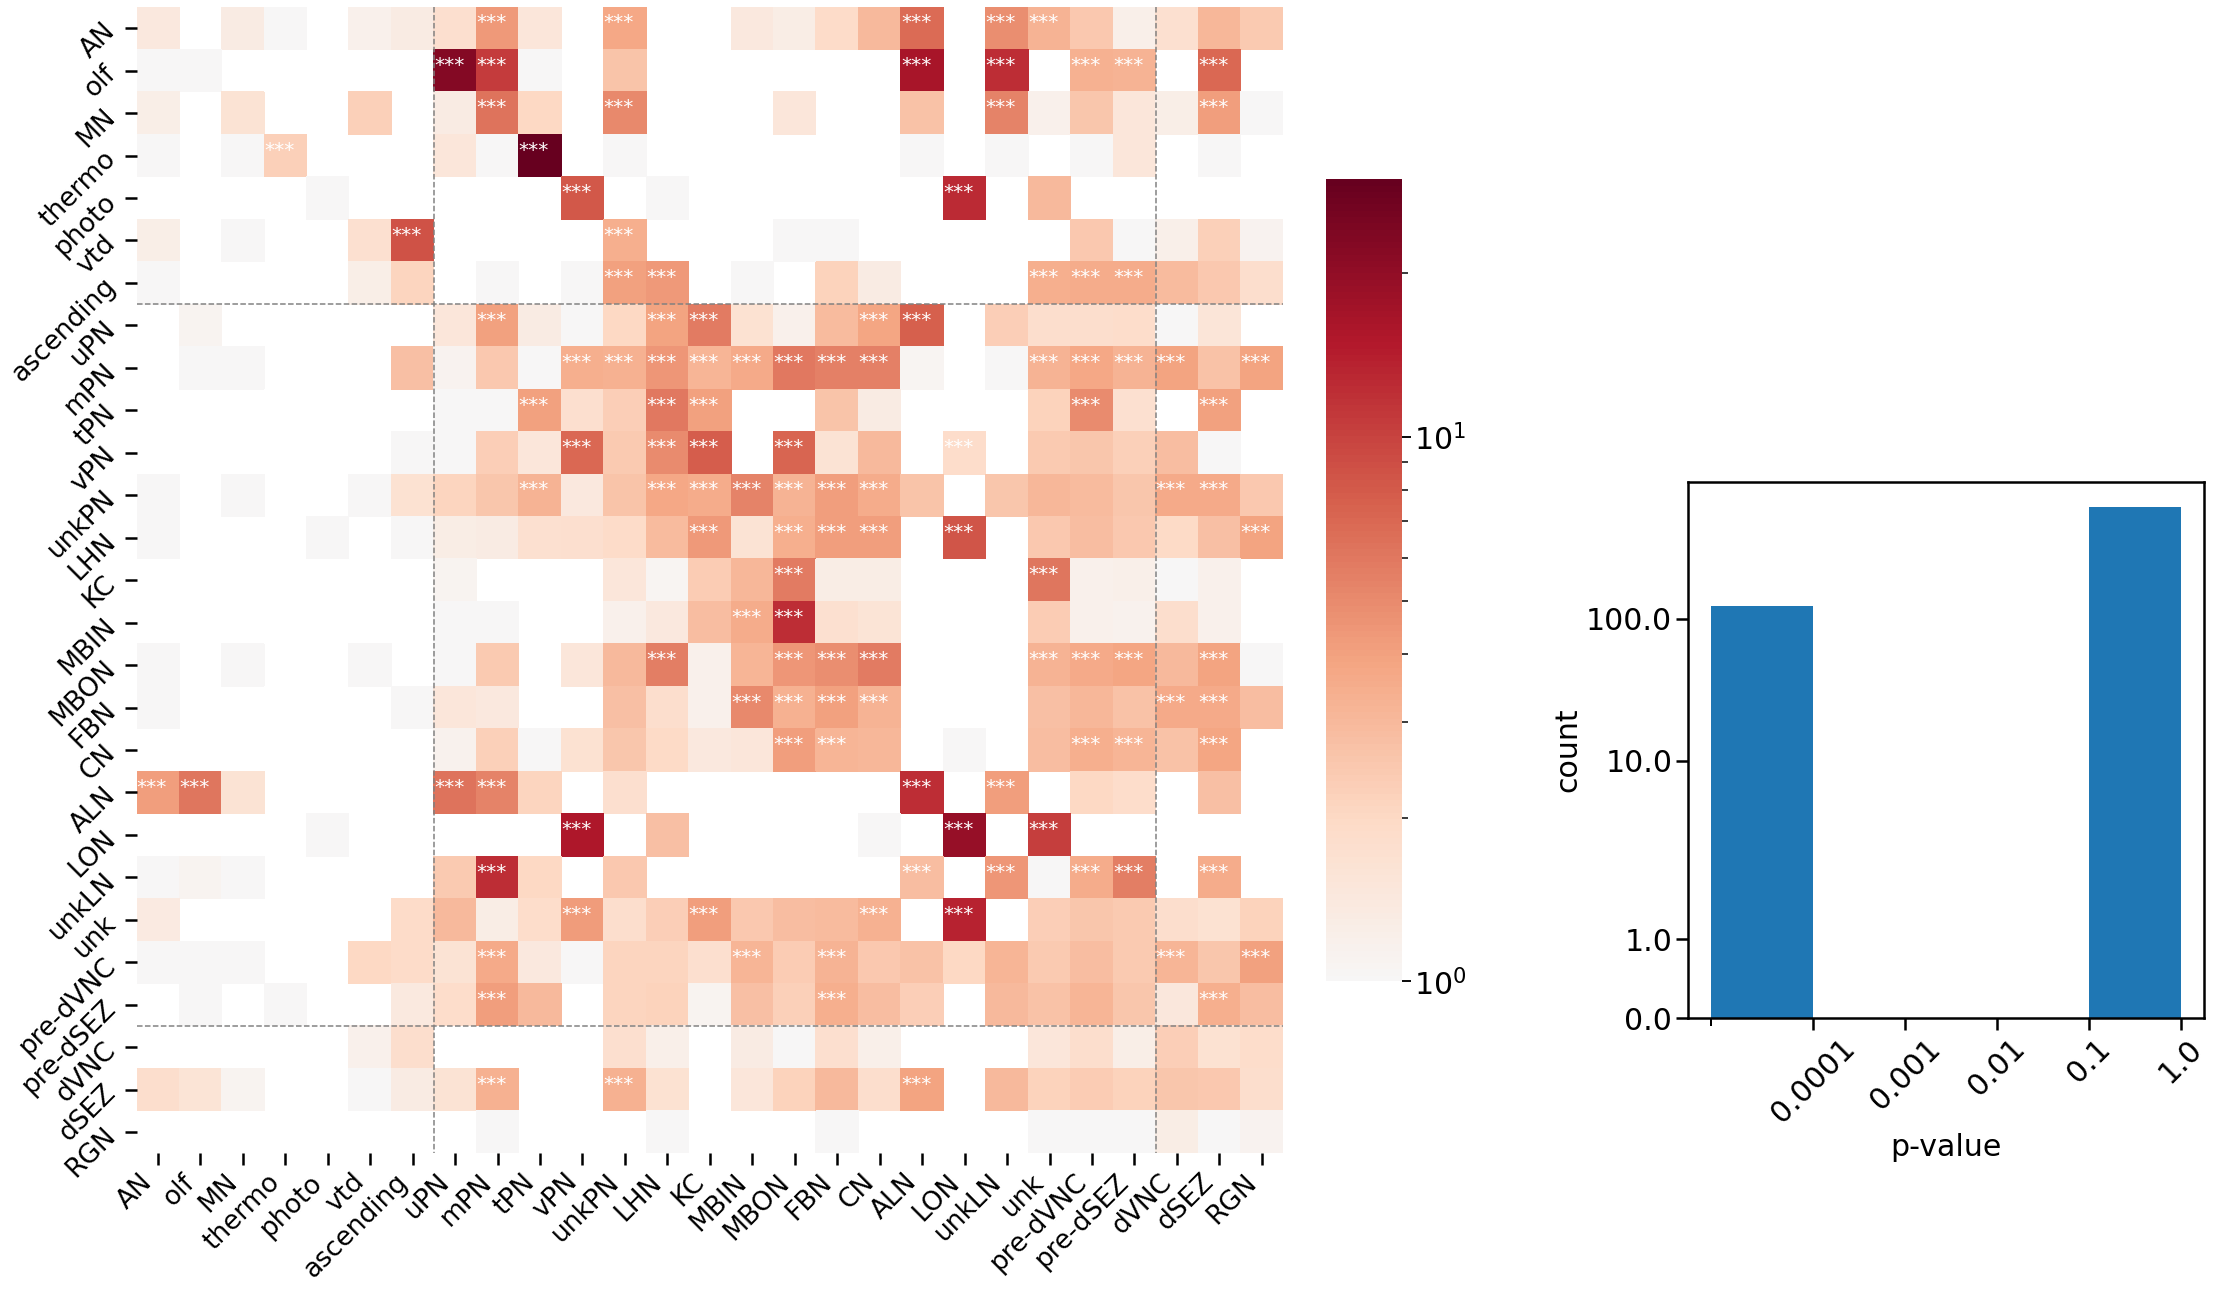

In [15]:
plot_heatmap(block_p, new_labels, p_val, block_pairs)

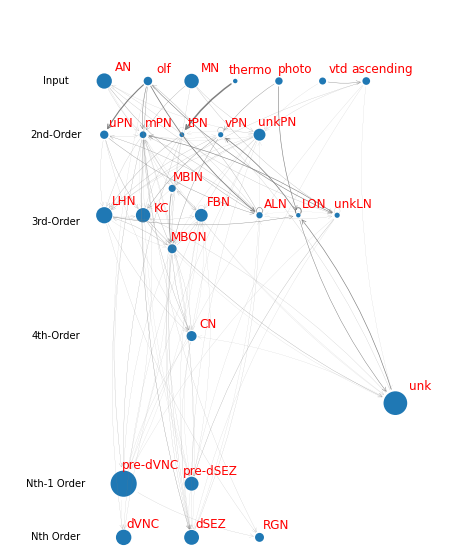

In [16]:
plot_connectivity(cls, block_pairs, block_p, p_val)

#%%[markdown]
# ### look at the distribution of the edge weights grouped by source & destination

[Text(0.5, 0, 'Edge Weight'), Text(0, 0.5, 'Density')]

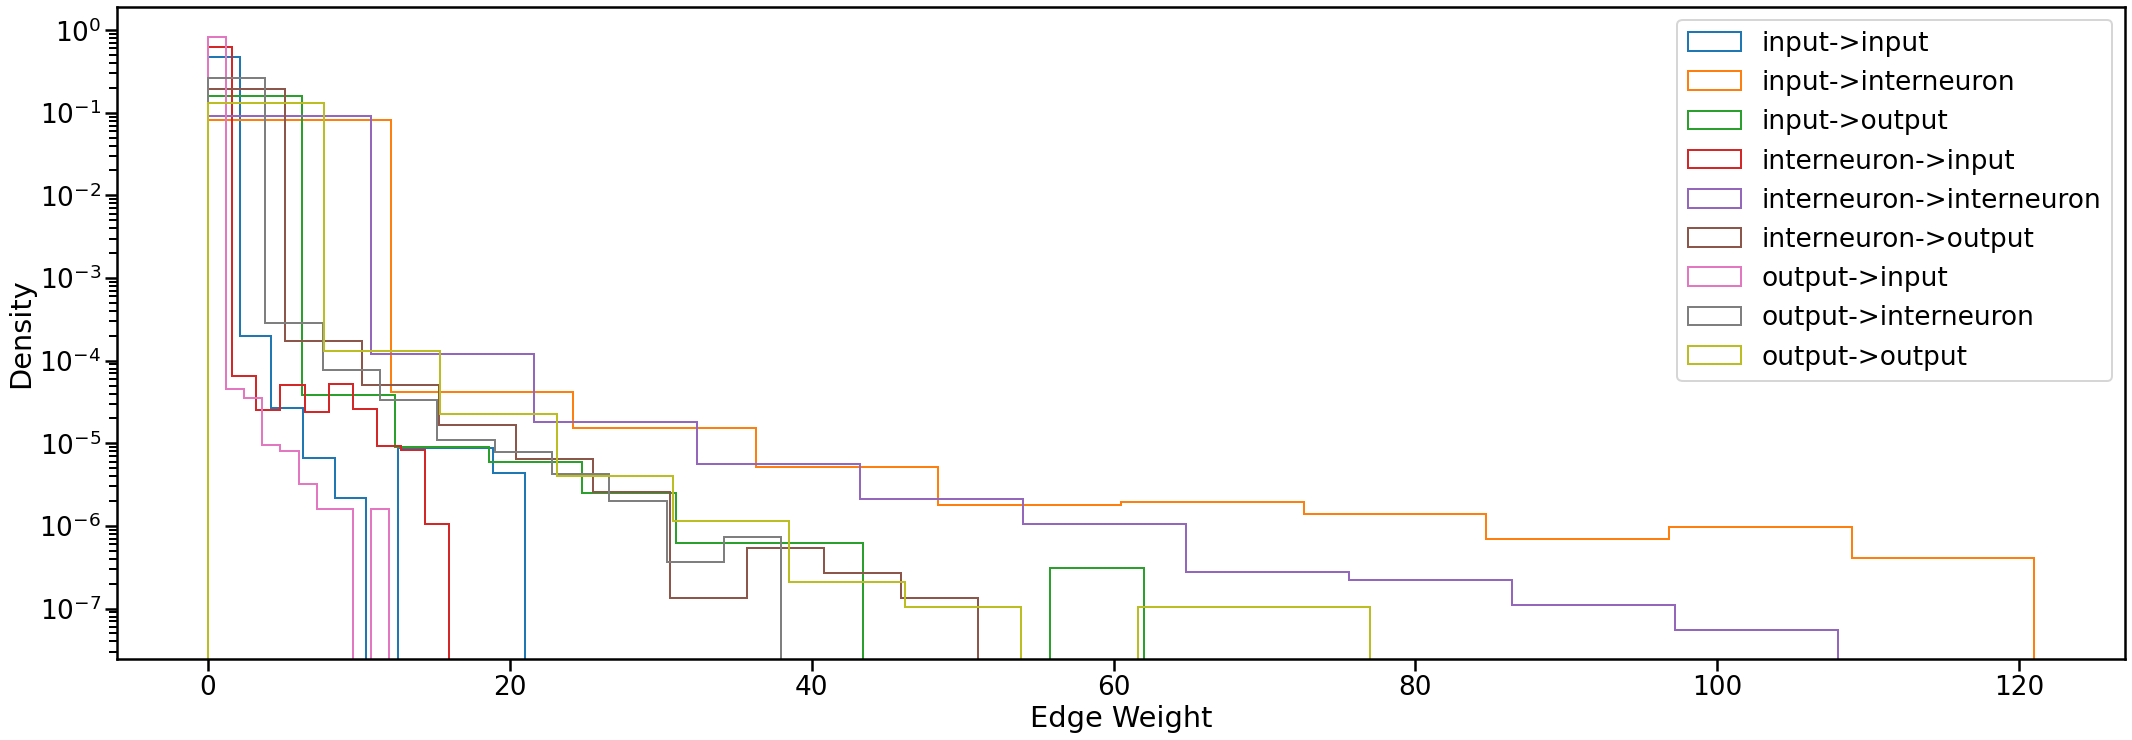

In [17]:
fig,ax = plt.subplots(1,figsize=(36,12))
labels = ['input', 'interneuron', 'output']
for i in range(3):
    for j in range(3):
        idx1 = np.where(meta['class_1'] == i)[0]
        idx2 = np.where(meta['class_1'] == j)[0]
        adj_sub = adj[np.ix_(idx1, idx2)]
        ax.hist(adj_sub.ravel(), log=True, density=True,
        label=labels[i]+"->"+labels[j], histtype=u'step')
ax.legend()
ax.set(xlabel='Edge Weight', ylabel='Density')


#%%[markdown]
# ### evaluate fitted SBMs

In [18]:
bic = np.zeros((3,2))
lik = np.zeros((3,2))
n_params = np.zeros((3,2))
all_cls = ['class_1', 'simple_group', 'class_4']
estimators = [sbms, sbms_hemi]
for i in range(len(all_cls)):
    labeled = np.where(meta[all_cls[i]].ne(''))[0]
    adj_new = adj[np.ix_(labeled, labeled)]
    for ii,e in enumerate(estimators):
        e[i].n_verts = len(adj_new)
        bic[i,ii] = e[i].bic(binarize(adj_new))
        lik[i,ii] = e[i].score(binarize(adj_new))
        n_params[i,ii] = e[i]._n_parameters()

/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


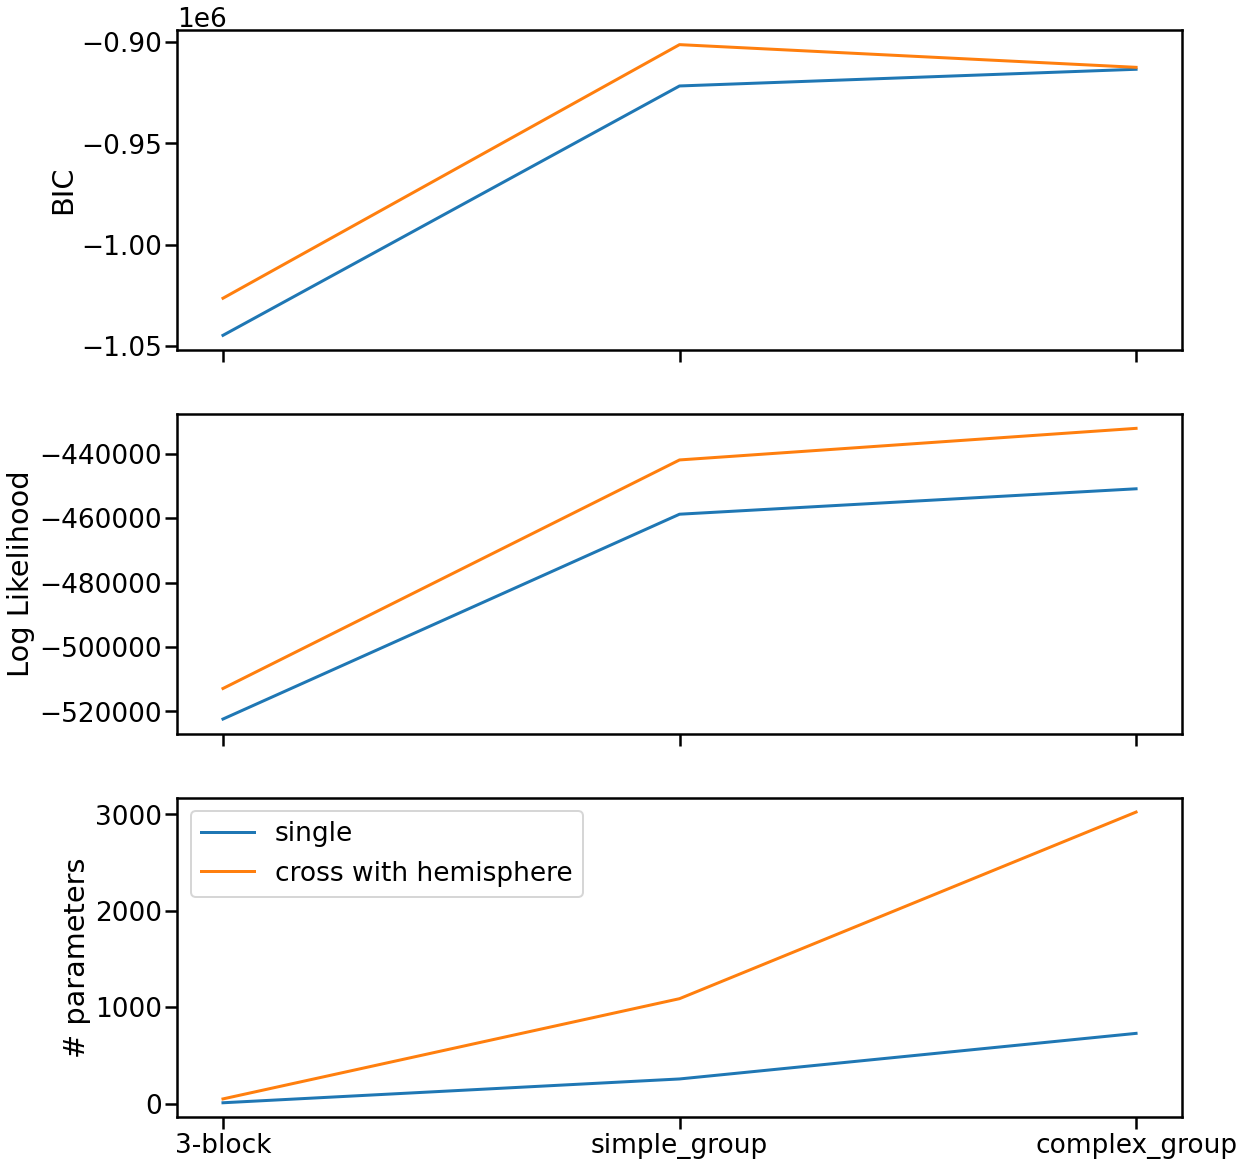

In [19]:
fig,axs = plt.subplots(3,1,figsize=(18,20))
data = [-bic, lik, n_params]
ylabels = ['BIC', 'Log Likelihood', '# parameters']
for i in range(len(data)):
    ax = axs[i]
    ax.plot(data[i][:,0], label='single')
    ax.plot(data[i][:,1], label='cross with hemisphere')
    ax.set_ylabel(ylabels[i])
    if i < 2:
        ax.set(xticklabels='', xticks=range(3))
    else:
        ax.set(xticklabels=['3-block', 'simple_group', 'complex_group'],
        xticks=range(3))
        ax.legend()